## Transfer learning

**Transfer learning** consists of taking weights, and hence feature representations, learned on one problem, and leveraging them on a new, similar problem. In the following experiment, we will use a [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) {cite}`mobilenet` model pretrained on ImageNet. This has around 2.3 million parameters and was designed to have fast inference times for resource constrained environments. This section follows the Keras guide [*Transfer learning & fine-tuning*](https://keras.io/guides/transfer_learning/). 


```{margin}
**Figure 8.12** in {cite}`keras2`
``` 
```{figure} ../../img/transfer-learning.png
---
width: 40em
---
Replacing with a new classifiers while keeping the same convolutional base.
```

Observe that the convolutional networks we encountered consist of two subnetworks: a convolutional base, that acts as a feature extractor, and a classifier on top of the base network that processes the extracted features to get class probabilities. The idea behind transfer learning is that we can take the convolutional base, that is extensively trained on a large dataset, and use its learned representations to train a new classifier on a similar task. This leads us to the following workflow:

 1. Instantiate a base model and load pre-trained weights into it.
 2. Freeze all layers in the base model by setting its `trainable` attribute to `False`.
 4. Add new layers on top of the base model.
 5. Train your new model on your new dataset.

An alternative workflow is to pass the input data *once* to the base model to get feature vectors. These vectors are then used to train a new, smaller model. This is cheaper, but we cannot use it along with data augmentation which transforms input data at each training iteration.

In [ ]:
base_model = kr.applications.MobileNetV2(
    weights='imagenet',         # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),    # We will have to resize for our 64x64x3 train dataset.
    include_top=False           # Do not include the ImageNet classifier at the top.
)

# Freeze the weights
base_model.trainable = False

# Stack a classification subnetwork on top of base model
inputs = kr.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)          # Inference mode! ⚠⚠⚠
x = kr.layers.GlobalAveragePooling2D()(x)       # 3x3x1280 -> 1x1x1280. Remove for performance. 
x = kr.layers.Flatten()(x)
x = kr.layers.Dense(256, activation='relu')(x)
x = kr.layers.Dropout(0.5)(x)
outputs = kr.layers.Dense(1)(x)

model = kr.Model(inputs, outputs)
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
________________________________________________________________

**Remark.** Instantiating the base model in inference mode is important as discussed in the following section.

In [ ]:
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Fit model with data augmentation
hist_transfer = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_valid
)

Epoch 1/20
500/500 [==============================] - 24s 39ms/step - loss: 0.5809 - binary_accuracy: 0.6957 - val_loss: 0.5184 - val_binary_accuracy: 0.7200
Epoch 2/20
500/500 [==============================] - 21s 39ms/step - loss: 0.5233 - binary_accuracy: 0.7297 - val_loss: 0.5058 - val_binary_accuracy: 0.7510
Epoch 3/20
500/500 [==============================] - 20s 38ms/step - loss: 0.5068 - binary_accuracy: 0.7374 - val_loss: 0.4912 - val_binary_accuracy: 0.7480
Epoch 4/20
500/500 [==============================] - 21s 40ms/step - loss: 0.4971 - binary_accuracy: 0.7426 - val_loss: 0.4893 - val_binary_accuracy: 0.7520
Epoch 5/20
500/500 [==============================] - 21s 38ms/step - loss: 0.4872 - binary_accuracy: 0.7516 - val_loss: 0.4839 - val_binary_accuracy: 0.7460
Epoch 6/20
500/500 [==============================] - 22s 42ms/step - loss: 0.4853 - binary_accuracy: 0.7499 - val_loss: 0.4893 - val_binary_accuracy: 0.7500
Epoch 7/20
500/500 [==============================] 

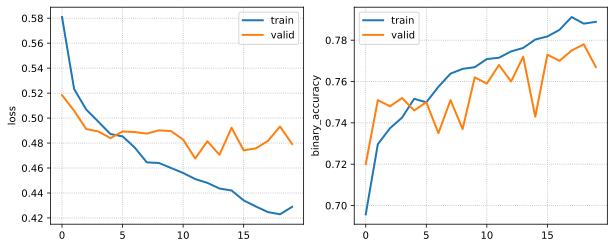

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist_transfer, ax=ax, metric='binary_accuracy', linewidth=2)

In [ ]:
print(f"Train accuracy: {model.evaluate(ds_train, verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(ds_valid, verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(ds_test,  verbose=0)[1] * 100:.2f}%")

Train accuracy: 81.52%
Valid accuracy: 76.70%
Test accuracy:  77.50%


### Fine-tuning

A last optional step is **fine-tuning** which consists of unfreezing the pre-trained model, or part of it, on the new task with very low learning rate. This can potentially achieve meaningful improvements. But could also potentially lead to quick overfitting due to the potentially large number of parameters in the base model which is why we use a small learning rate. 

Note that it is critical to fine-tune a model only after the model with frozen layers has been trained to convergence. Mixing pretrained layers with randomly initialized layers will destroy the pretrained weights due to large gradient updates during the early stages of training.

In [ ]:
# Unfreeze the base model.
base_model.trainable = True

# Recompile to take unfreezing into account.
model.compile(
    optimizer=kr.optimizers.Adam(1e-5),  # Very low learning rate
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Stop before it overfits!
callback = kr.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

# Batch normalization still runs in inference mode. (See appendix.)
epochs = 10
hist_finetune = model.fit(
    ds_train,
    epochs=epochs, 
    validation_data=ds_valid,
    callbacks=[callback]
)

Epoch 1/10
500/500 [==============================] - 36s 62ms/step - loss: 0.3840 - binary_accuracy: 0.8120 - val_loss: 0.3934 - val_binary_accuracy: 0.8090
Epoch 2/10
500/500 [==============================] - 32s 61ms/step - loss: 0.3120 - binary_accuracy: 0.8520 - val_loss: 0.3763 - val_binary_accuracy: 0.8240
Epoch 3/10
500/500 [==============================] - 32s 61ms/step - loss: 0.2786 - binary_accuracy: 0.8700 - val_loss: 0.3986 - val_binary_accuracy: 0.8110
Epoch 4/10
500/500 [==============================] - 32s 60ms/step - loss: 0.2572 - binary_accuracy: 0.8813 - val_loss: 0.2930 - val_binary_accuracy: 0.8690
Epoch 5/10
500/500 [==============================] - 32s 61ms/step - loss: 0.2351 - binary_accuracy: 0.8941 - val_loss: 0.2876 - val_binary_accuracy: 0.8660
Epoch 6/10
500/500 [==============================] - 31s 59ms/step - loss: 0.2231 - binary_accuracy: 0.8973 - val_loss: 0.2929 - val_binary_accuracy: 0.8620
Epoch 7/10
500/500 [==============================] 

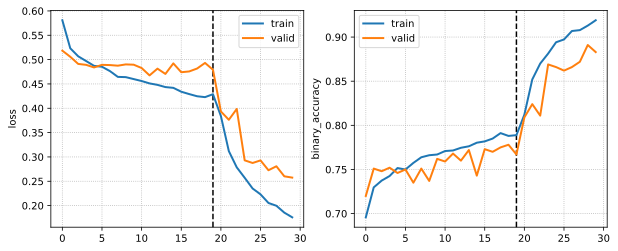

In [ ]:
for key in hist_transfer.history.keys():
    hist_finetune.history[key] = hist_transfer.history[key] + hist_finetune.history[key]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axvline(len(hist_transfer.history["loss"]) - 1, color="black", linestyle="dashed")
ax[1].axvline(len(hist_transfer.history["loss"]) - 1, color="black", linestyle="dashed")
plot_model_history(history=hist_finetune, ax=ax, metric="binary_accuracy", linewidth=2)

Fine-tuning drastically improves model performance, but as expected the model quickly overfits after a few epochs due to overcapacity. Although we were not able to obtain a better scores below with fine-tuning compared to our previous smile classification convnet, we expect better results using more powerful hardware.

In [ ]:
print(f"train acc: {model.evaluate(ds_train, verbose=0)[1] * 100:.2f}%")
print(f"valid acc: {model.evaluate(ds_valid, verbose=0)[1] * 100:.2f}%")
print(f"test  acc: {model.evaluate(ds_test,  verbose=0)[1] * 100:.2f}%")

train acc: 93.60%
valid acc: 88.30%
test  acc: 89.60%


### Appendix: BatchNorm

Freezing weights (`trainable=False`) make BatchNorm layers run in inference mode (`training=False`). This is not overridden by running the wrapping model in training mode. This means that BatchNorm statistics will not update during transfer learning. Note that while `trainable` and `training` are orthogonal concepts in principle, this default behavior makes sense since the trainable parameters in the BatchNorm layers of the base model are fixed during transfer learning.

To check this behavior, we define a function that prints the sum of BatchNorm statistics before and after a call in training mode:

In [ ]:
def simulate_train(model, bn_index, batch_size=512):
    """Print sum of BN weights before and after a train step."""
    
    bn = model.layers[bn_index]
    γ0 = bn.weights[0].numpy()[0]
    μ0 = bn.weights[2].numpy()[0]

    # train step: (1) pass input at train time + (2) update weights 
    with tf.GradientTape() as tape:
        z = model(tf.random.normal([batch_size,]), training=True)

    grads = tape.gradient(z, model.trainable_weights)
    for w, g in zip(model.trainable_variables, grads):
        dw = 10.0 * g
        w.assign_add(-dw)

    γ1 = bn.weights[0].numpy()[0]
    μ1 = bn.weights[2].numpy()[0]

    print(f"(γ):  {γ0} -> {γ1}")
    print(f"(μ):  {μ0} -> {μ1}")

Recall that the standard recipe for transfer learning is to instantiate `base_model` in **inference** mode. Results below also show that this will not be overridden by running the wrapper model in train mode after being initialized in inference mode, so that the layers of the base model will continue to run in inference mode even when we unfreeze the weights during fine-tuning:

In [ ]:
# (1a) Freezing weights => BN inference mode.
base_model = kr.layers.BatchNormalization()
base_model.trainable = False

# (1b) Initializing base model in inference mode
x = kr.Input(shape=(1,))
h = base_model(x, training=False)
y = tf.reduce_sum(tf.math.tanh(h) ** 2)
model = kr.Model(x, y)

print("Simulating transfer learning")
simulate_train(model, 1)

# (2) Unfreezing base model weights for fine-tuning
base_model.trainable = True
print("\nSimulating fine-tuning")
simulate_train(model, 1)

Simulating transfer learning
(γ):  1.0 -> 1.0
(μ):  0.0 -> 0.0

Simulating fine-tuning
(γ):  1.0 -> -1853.3482666015625
(μ):  0.0 -> 0.0


This prevents updates on non-trainable weights which are not scaled by the learning rate (set to be really small during fine-tuning) and may suddenly destroy what the model has learned during transfer learning. On the other hand, initializing the model **not** in inference mode results in updates of the moving mean when we unfreeze weights and train for fine-tuning:

In [ ]:
# (1a) Freezing weights => BN inference mode.
base_model = kr.layers.BatchNormalization()
base_model.trainable = False

# (1b) Initializing base model NOT in inference mode
x = kr.Input(shape=(1,))
h = base_model(x)                          # <- (!!)
y = tf.reduce_sum(tf.math.tanh(h) ** 2)
model = kr.Model(x, y)

print("Simulating transfer learning")
simulate_train(model, 1)

# (2) Unfreezing base model weights for fine-tuning
base_model.trainable = True
print("\nSimulating fine-tuning")
simulate_train(model, 1)

Simulating transfer learning
(γ):  1.0 -> 1.0
(μ):  0.0 -> 0.0

Simulating fine-tuning
(γ):  1.0 -> -1852.6986083984375
(μ):  0.0 -> 0.0004891009302809834
